#### Lets do the analytics with the help of pandas, sql and matplotlib


In [1]:
### Libraries we will be using ! 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.stats import f_oneway
from scipy.stats import shapiro
from scipy.stats import kruskal

### Connecting to the sql server using Docker




In [2]:
import psycopg2
connection = psycopg2.connect(
    host="localhost",
    port=5432,
    database="postgres",   # DB name
    user="postgres",       # DB user
    password="Suz@ljune13" # DB password
)


In [3]:
data = pd.read_sql('select * from cleaned where "Age" > 12;', connection)
data.head(5)


/var/folders/bt/9_3kc80d4jq8sv8fv_c7d_fr0000gn/T/ipykernel_31374/2023419232.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql('select * from cleaned where "Age" > 12;', connection)


,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,...,cal_from_macros,pct_carbs,protein_per_kg,pct_HRR,pct_maxHR,cal_balance,lean_mass_kg,expected_burn,Burns Calories (per 30 min)_bc,Burns_Calories_Bin
0,34.91,Male,65.27,1.62,188.58,157.65,69.05,1.00,1080.90,Strength,...,2139.59,0.500432,1.624789,0.741236,0.835985,725.10,47.777393,685.1600,7.260425e+19,Medium
1,23.37,Female,56.41,1.55,179.43,131.75,73.18,1.37,1809.91,HIIT,...,1711.65,0.500850,1.514093,0.551247,0.734270,-232.91,40.809803,978.6184,1.020506e+20,High
2,33.20,Female,58.98,1.67,175.04,123.95,54.96,0.91,802.26,Cardio,...,1965.92,0.500610,1.663445,0.574534,0.708124,805.74,44.635580,654.5266,1.079607e+20,High
3,38.69,Female,93.78,1.70,191.21,155.10,50.07,1.10,1450.79,HIIT,...,1627.28,0.499533,0.862017,0.744155,0.811150,1206.21,63.007430,773.6300,8.987921e+19,High
4,45.09,Male,52.42,1.88,193.58,152.88,70.84,1.08,1166.40,Strength,...,2659.23,0.500581,2.538153,0.668405,0.789751,303.60,43.347504,711.4176,5.264685e+19,Low


In [5]:
print(data.columns)

Index(['Age', 'Gender', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM',
       'Resting_BPM', 'Session_Duration (hours)', 'Calories_Burned',
       'Workout_Type', 'Fat_Percentage', 'Water_Intake (liters)',
       'Workout_Frequency (days/week)', 'Experience_Level', 'BMI',
       'Daily meals frequency', 'Physical exercise', 'Carbs', 'Proteins',
       'Fats', 'Calories', 'meal_name', 'meal_type', 'diet_type', 'sugar_g',
       'sodium_mg', 'cholesterol_mg', 'serving_size_g', 'cooking_method',
       'prep_time_min', 'cook_time_min', 'rating', 'Name of Exercise', 'Sets',
       'Reps', 'Benefit', 'Burns Calories (per 30 min)', 'Target Muscle Group',
       'Equipment Needed', 'Difficulty Level', 'Body Part', 'Type of Muscle',
       'Workout', 'BMI_calc', 'cal_from_macros', 'pct_carbs', 'protein_per_kg',
       'pct_HRR', 'pct_maxHR', 'cal_balance', 'lean_mass_kg', 'expected_burn',
       'Burns Calories (per 30 min)_bc', 'Burns_Calories_Bin'],
      dtype='object')


---
## Data Analytics Questions 

###  IS THERE A SIGNIFICANT DIFFERENCE IN THE CALORIES BURNED PER WORKOUT SESSION BETWEEN USERS OF DIFFERENT Experience_Level?


/var/folders/bt/9_3kc80d4jq8sv8fv_c7d_fr0000gn/T/ipykernel_31374/3086352161.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  calories_burned = pd.read_sql(query, connection)
/opt/anaconda3/envs/Fitness_App/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6710.
  res = hypotest_fun_out(*samples, **kwds)
/opt/anaconda3/envs/Fitness_App/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10856.
  res = hypotest_fun_out(*samples, **kwds)


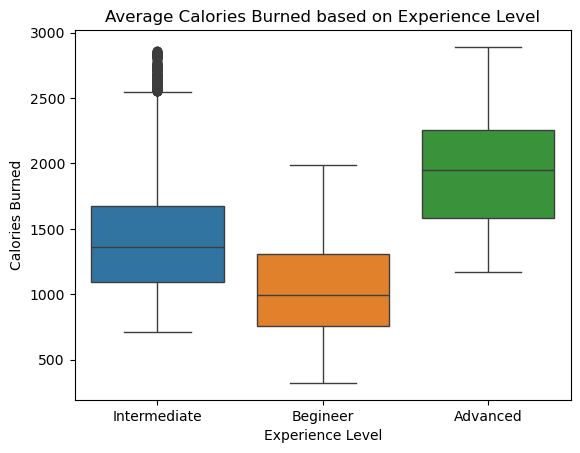

In [36]:
query = """
    with calories_burned as (
	select "Calories_Burned",
	case 
		when "Experience_Level" < 2.0 then 'Begineer'
		when "Experience_Level" >= 2.0 and "Experience_Level" < 3.0 then 'Intermediate'
		else 'Advanced'
	end as Experience_Status
	from cleaned
	
)

select * from calories_burned

"""

calories_burned = pd.read_sql(query, connection)

### Lets check the normality of the data

calories_burned.head(5)
for types in calories_burned['experience_status'].unique():
    stats,p_value = shapiro(calories_burned[calories_burned['experience_status'] == types]['Calories_Burned'])
    ## All the p_values are less than 0.05 which means that they are non-normal which means we will be using non-parametric testing


## Kruskal Testing for Hypothesis 
groups = [calories_burned[calories_burned['experience_status'] == types]['Calories_Burned'] for types in calories_burned['experience_status'].unique()]
stats, p_value = kruskal(*groups) ##p_value <0.05 which means we reject the null hypothesis


## Visual Proof 
calories_experience = calories_burned.groupby('experience_status').agg({"Calories_Burned":"mean"}).reset_index()

sns.boxplot(x = 'experience_status', y = 'Calories_Burned', data = calories_burned, hue = 'experience_status')
plt.xlabel("Experience Level")
plt.ylabel("Calories Burned")
plt.title("Average Calories Burned based on Experience Level")
plt.show()


### From the graph and the hypothesis testing we can reject the null hypothesis stating there is no significnat difference in the Average Calories Burned across the Experience Level.